<h2> Vacation Itinerary Planner </h2>
<h6> By Arun Thomas </h6>


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as Soup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab
usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


Using FourSquare API to get the information of the nearest 25 venues

In [6]:
CLIENT_ID = 'SQWL1VDNKLG3X4BDQACQKBKMHJBSQTX5NQDZHCNTHUTAIAA2' # your Foursquare ID
CLIENT_SECRET = 'K5PAPTM35CLCRQM5LAZ2Y0XDBC4ZAUOEGS5GKPJ2L0NCD5FY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SQWL1VDNKLG3X4BDQACQKBKMHJBSQTX5NQDZHCNTHUTAIAA2
CLIENT_SECRET:K5PAPTM35CLCRQM5LAZ2Y0XDBC4ZAUOEGS5GKPJ2L0NCD5FY


In [10]:
LIMIT = 25 # limit of number of venues returned by Foursquare API
radius = 50000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
print(url)



https://api.foursquare.com/v2/venues/explore?&client_id=SQWL1VDNKLG3X4BDQACQKBKMHJBSQTX5NQDZHCNTHUTAIAA2&client_secret=K5PAPTM35CLCRQM5LAZ2Y0XDBC4ZAUOEGS5GKPJ2L0NCD5FY&v=20180605&ll=48.8566969,2.3514616&radius=50000&limit=25


In [11]:
geolocator = Nominatim(user_agent="virtualplanner")
location = geolocator.geocode("Paris, France")
print((location.latitude, location.longitude))

neighborhood_latitude = location.latitude
neighborhood_longitude = location.longitude


(48.8566969, 2.3514616)


In [12]:
results = requests.get(url).json()


In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
map_kml = r"C:\Users\athomas\Downloads\coordnate data.kml" # imported kml file from Google Maps

with open(map_kml) as data:
    kml_soup = Soup(data, 'lxml-xml') # Parse as XML
coords = kml_soup.find_all('coordinates') # find all the coordinates
coords_list = []
for x in coords:
    coords_list.append(str(x)) # store the coordinates in a list

In [25]:
names = kml_soup.find_all('name') # find all the coordinates
names_list = []
for x in names:
    names_list.append(str(x)) # store the coordinates in a list
    
    # create new dataframe
coord_col = ['Longitude', 'Latitude', 'Landmark']
df_coord = pd.DataFrame(columns=coord_col) 
# split coordinates list into coordinates to populate the dataframe
for i, j in zip(range(len(coords_list)), range(2, len(names_list))):
    item = coords_list[i]
    string_split = item.split(',')
    coord1 = float(string_split[0][26:])
    coord2 = float(string_split[1])
    coord3 = names_list[j][6:-7]
    df_coord.loc[i] = [coord1, coord2, coord3]
    
print(df_coord)

    Longitude   Latitude                                   Landmark
0    2.328528  48.846271        French Alliance Paris Ile-De-France
1    2.289282  48.861596                         TrocadÃ©ro Gardens
2    2.293046  48.856093                               Eiffel Tower
3    2.340802  48.886503                            Place du Tertre
4    2.343030  48.886711  The Basilica of the Sacred Heart of Paris
5    2.300457  48.871545      Louis Vuitton Maison Champs Ã‰lysÃ©es
6    2.331978  48.873734               Galeries Lafayette Haussmann
7    2.331601  48.871970                             Palais Garnier
8    2.328071  48.874010                        Printemps Haussmann
9    2.337644  48.860611                              Louvre Museum
10   2.120355  48.804865                       Palace of Versailles
11   2.305937  48.864011                            Bateaux-Mouches
12   2.783593  48.867386                           Disneyland Paris
13   2.352245  48.860642                        

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues = df_coord

<ipython-input-27-fb2d5f4b81ff>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


In [54]:
# create map of Paris using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Landmark in zip(df_coord['Latitude'], df_coord['Longitude'], df_coord['Landmark']):
    label = '{}'.format(Landmark)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    


NameError: name 'latitude' is not defined

In [28]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

26 venues were returned by Foursquare.


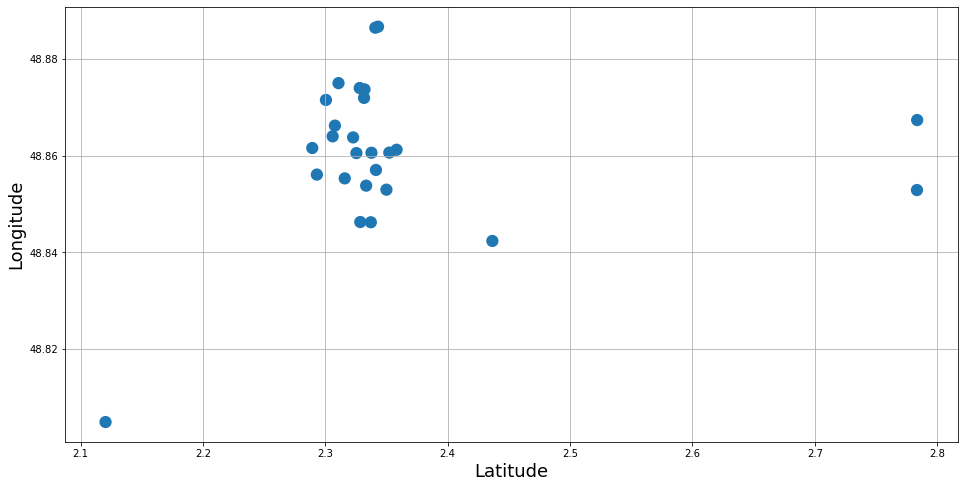

In [30]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(df_coord['Longitude'], df_coord['Latitude'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.grid()
plt.show()

## k-means Clustering of Geo Locations

In [31]:
from sklearn.cluster import KMeans # Importing KMeans
# Creating an instance of KMeans to find 10 clusters
kmeans_1 = KMeans(n_clusters=10)
# Using fit_predict to cluster the dataset
X = df_coord[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X) 

In [32]:
clustered = pd.concat([df_coord.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)

In [33]:
clustered.drop('index', axis=1, inplace=True)

In [34]:
conditions = [
    clustered['Cluster'] == 0, 
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4,
    clustered['Cluster'] == 5,
    clustered['Cluster'] == 6,
    clustered['Cluster'] == 7,
    clustered['Cluster'] == 8,
    clustered['Cluster'] == 9 ]
choices = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 
           'Sunday', 'Monday', 'Tuesday', 'Wednesday' ]
clustered['Vacation Day'] = np.select(conditions, choices, default='black')

In [35]:
clustered.sort_values(by=['Cluster'])

,Longitude,Latitude,Landmark,Cluster,Vacation Day
1,2.289282,48.861596,TrocadÃ©ro Gardens,0,Monday
2,2.293046,48.856093,Eiffel Tower,0,Monday
12,2.783593,48.867386,Disneyland Paris,1,Tuesday
17,2.783418,48.852891,La Vallee Village,1,Tuesday
10,2.120355,48.804865,Palace of Versailles,2,Wednesday
16,2.341325,48.857050,Pont Neuf,3,Thursday
15,2.337160,48.846222,Luxembourg Gardens,3,Thursday
24,2.333328,48.853798,Saint-Germain-des-PrÃ©s,3,Thursday
9,2.337644,48.860611,Louvre Museum,3,Thursday
0,2.328528,48.846271,French Alliance Paris Ile-De-France,3,Thursday


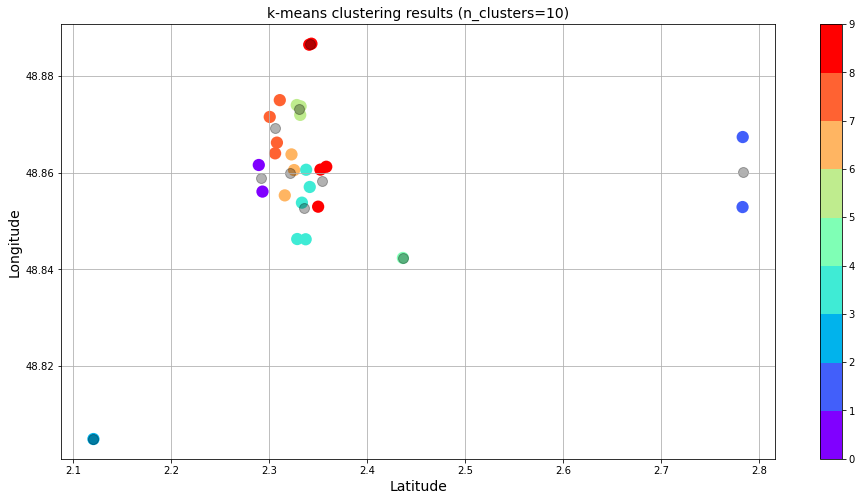

In [36]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
#plt.xlim(2.28, 2.375)
#plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=10)', fontsize=14)
plt.grid()
plt.show()

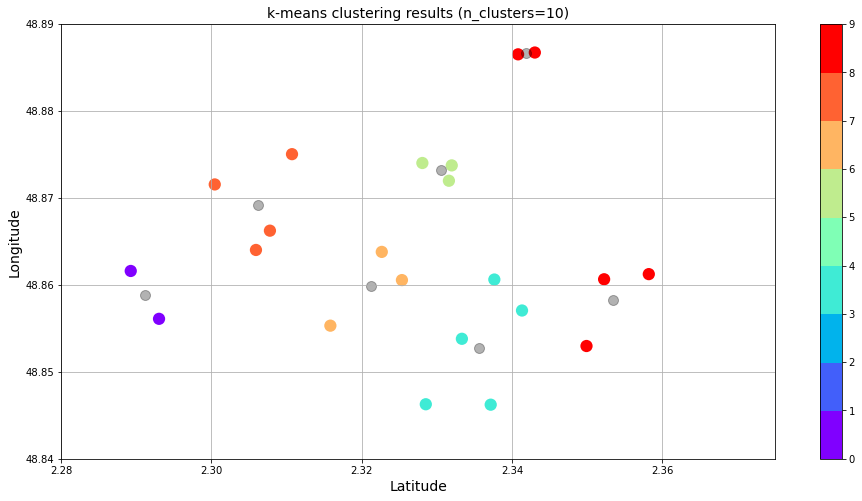

In [37]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
plt.xlim(2.28, 2.375)
plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=10)', fontsize=14)
plt.grid()
plt.show()

## HDBSCAN Clustering of Geo Locations

In [45]:
!conda install -c conda-forge hdbscan --yes

import hdbscan

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Anaconda

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    hdbscan-0.8.27             |   py38h347fdf6_0         529 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  hdbscan            conda-forge/win-64::hdbscan-0.8.27-py38h347fdf6_0
  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38

The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38haa95532_0 --> conda-forge::conda-4.9.2-py38haa2

In [47]:


rads = np.radians(X)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine')
predictions = clusterer.fit_predict(rads)

In [48]:
clustered = pd.concat([df_coord.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)
clustered.drop('index', axis=1, inplace=True)
conditions = [
    clustered['Cluster'] == -1, 
    clustered['Cluster'] == 0,
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4,
    clustered['Cluster'] == 5,
    clustered['Cluster'] == 6,
    clustered['Cluster'] == 7,
    clustered['Cluster'] == 8 ]
choices = ['NA/Noise', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
           'Friday','Saturday', 'Sunday', 'Monday', 'Tuesday' ]
clustered['Vacation Day'] = np.select(conditions, choices, default='black')
clustered.sort_values(by=['Cluster'])

,Longitude,Latitude,Landmark,Cluster,Vacation Day
23,2.315835,48.855307,Rodin Museum,-1,NA/Noise
20,2.436470,48.842348,Sainte-Chapelle de Vincennes,-1,NA/Noise
10,2.120355,48.804865,Palace of Versailles,-1,NA/Noise
12,2.783593,48.867386,Disneyland Paris,0,Monday
17,2.783418,48.852891,La Vallee Village,0,Monday
3,2.340802,48.886503,Place du Tertre,1,Tuesday
4,2.343030,48.886711,The Basilica of the Sacred Heart of Paris,1,Tuesday
1,2.289282,48.861596,TrocadÃ©ro Gardens,2,Wednesday
2,2.293046,48.856093,Eiffel Tower,2,Wednesday
18,2.307796,48.866229,Champs-Ã‰lysÃ©es,3,Thursday


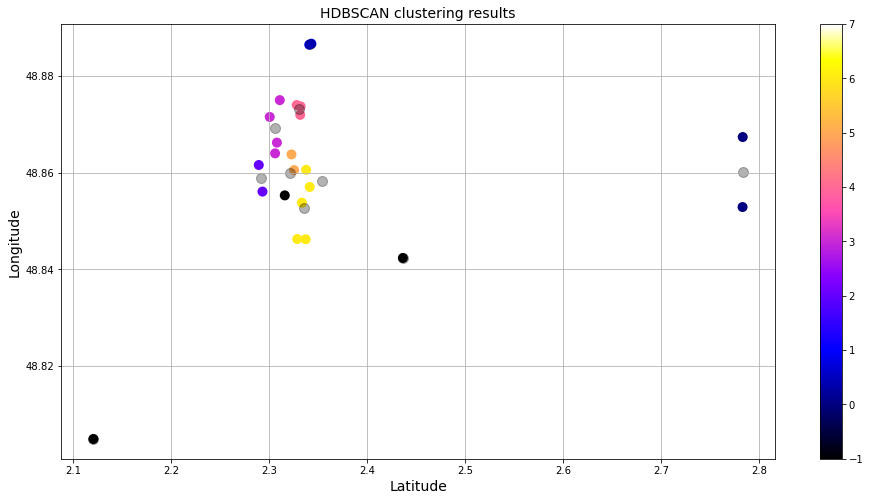

In [49]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.gnuplot2
#norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, s=100, edgecolor='none')
plt.colorbar(ticks=[-1,0,1,2,3,4,5,6,7,8])
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
#plt.xlim(2.28, 2.375)
#plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('HDBSCAN clustering results', fontsize=14)
plt.grid()
plt.show()

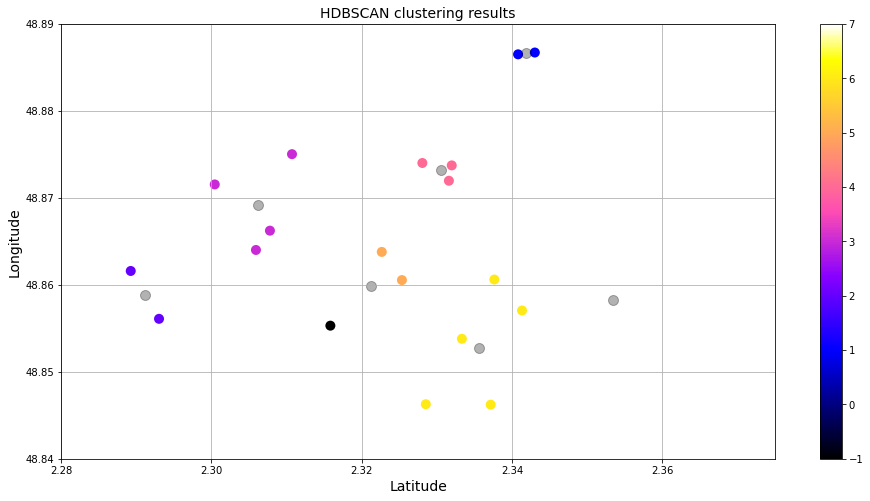

In [50]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.gnuplot2
#norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, s=100, edgecolor='none')
plt.colorbar(ticks=[-1,0,1,2,3,4,5,6,7,8])
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
plt.xlim(2.28, 2.375)
plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('HDBSCAN clustering results', fontsize=14)
plt.grid()
plt.show()

In [55]:
clustered.sort_values(by=['Cluster'])

,Longitude,Latitude,Landmark,Cluster,Vacation Day
23,2.315835,48.855307,Rodin Museum,-1,NA/Noise
20,2.436470,48.842348,Sainte-Chapelle de Vincennes,-1,NA/Noise
10,2.120355,48.804865,Palace of Versailles,-1,NA/Noise
12,2.783593,48.867386,Disneyland Paris,0,Monday
17,2.783418,48.852891,La Vallee Village,0,Monday
3,2.340802,48.886503,Place du Tertre,1,Tuesday
4,2.343030,48.886711,The Basilica of the Sacred Heart of Paris,1,Tuesday
1,2.289282,48.861596,TrocadÃ©ro Gardens,2,Wednesday
2,2.293046,48.856093,Eiffel Tower,2,Wednesday
18,2.307796,48.866229,Champs-Ã‰lysÃ©es,3,Thursday


## What we see above is the schedule for the 25 destinatations in Paris, arranged by cluster and by the distance between them.The first 3 entries are basically the noise, ie: they are far away from the other places. It is better to skip those places,- they would take a lot of time just to travel to reach them.